In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold  
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import matthews_corrcoef

In [2]:
# 데이터 로드
train = pd.read_csv('../travel/data/train.csv')
test = pd.read_csv('../travel/data/test.csv') 
sample_submission = pd.read_csv('../travel/data/sample_submission.csv')

In [3]:
# train_data 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1955 entries, 0 to 1954
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1955 non-null   int64  
 1   Age                       1861 non-null   float64
 2   TypeofContact             1945 non-null   object 
 3   CityTier                  1955 non-null   int64  
 4   DurationOfPitch           1853 non-null   float64
 5   Occupation                1955 non-null   object 
 6   Gender                    1955 non-null   object 
 7   NumberOfPersonVisiting    1955 non-null   int64  
 8   NumberOfFollowups         1942 non-null   float64
 9   ProductPitched            1955 non-null   object 
 10  PreferredPropertyStar     1945 non-null   float64
 11  MaritalStatus             1955 non-null   object 
 12  NumberOfTrips             1898 non-null   float64
 13  Passport                  1955 non-null   int64  
 14  PitchSat

In [4]:
# taget_data 확인
np.unique(train.ProdTaken, return_counts=True)

(array([0, 1], dtype=int64), array([1572,  383], dtype=int64))

In [5]:
# train_data 결측치 확인
train.isna().sum()

id                            0
Age                          94
TypeofContact                10
CityTier                      0
DurationOfPitch             102
Occupation                    0
Gender                        0
NumberOfPersonVisiting        0
NumberOfFollowups            13
ProductPitched                0
PreferredPropertyStar        10
MaritalStatus                 0
NumberOfTrips                57
Passport                      0
PitchSatisfactionScore        0
OwnCar                        0
NumberOfChildrenVisiting     27
Designation                   0
MonthlyIncome               100
ProdTaken                     0
dtype: int64

In [6]:
# test_data 결측치 확인
test.isna().sum()

id                            0
Age                         132
TypeofContact                15
CityTier                      0
DurationOfPitch             149
Occupation                    0
Gender                        0
NumberOfPersonVisiting        0
NumberOfFollowups            32
ProductPitched                0
PreferredPropertyStar        16
MaritalStatus                 0
NumberOfTrips                83
Passport                      0
PitchSatisfactionScore        0
OwnCar                        0
NumberOfChildrenVisiting     39
Designation                   0
MonthlyIncome               133
dtype: int64

In [7]:
# object 타입 데이터 변환

# 고객의 제품 인지 방법(회사의 홍보 or 스스로 검색)
for these in [train, test]:
    these['TypeofContact'] = these['TypeofContact'].map({'Unknown': 0, 'Self Enquiry': 1, 'Company Invited': 2})  

# 성별
for these in [train, test]:
    these['Gender'] = these['Gender'].map({'Male': 0, 'Female': 1, 'Fe Male': 1})  # 'Fe Male' -> 'Female'

# 직업 
for these in [train, test]:
    these['Occupation'] = these['Occupation'].map({'Salaried': 0, 'Small Business': 1, 'Large Business': 2, 'Free Lancer':3})

# 영업 사원이 제시한 상품 
for these in [train, test]:
    these['ProductPitched'] = these['ProductPitched'].map({'Super Deluxe': 0, 'King': 1, 'Deluxe': 2, 'Standard':3, 'Basic': 4})

# 결혼 여부 
for these in [train, test]:
    these['MaritalStatus'] = these['MaritalStatus'].map({'Divorced': 0, 'Married': 1, 'Unmarried': 2, 'Single':3})

# 직급 
for these in [train, test]:
    these['Designation'] = these['Designation'].map({'AVP': 0, 'VP': 1, 'Manager': 2, 'Senior Manager':3, 'Executive': 4})

Text(0.5, 1.0, 'correlation between columns')

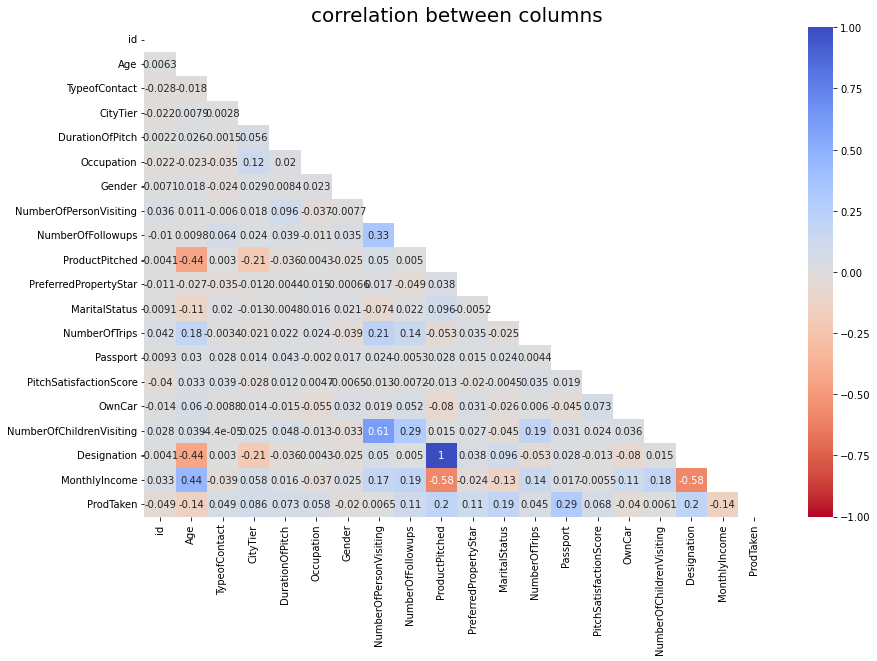

In [8]:
# 상관관계 분석도
plt.figure(figsize=(14, 9))
heat_table = train.corr()
mask = np.zeros_like(heat_table)
mask[np.triu_indices_from(mask)]=True
heatmap_ax = sns.heatmap(heat_table, annot=True, mask=mask, cmap='coolwarm_r', vmin=-1, vmax=1)
heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=10, rotation=90)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=10)
plt.title('correlation between columns', fontsize=20)

[Text(0.5, 1.0, 'Gender')]

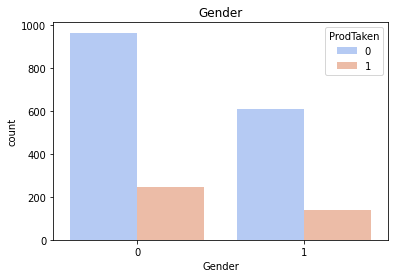

In [9]:
# 수치가 애매한 'Gender', 'OwnCar'의 여행 신청 여부 확인
palette = sns.color_palette('coolwarm', 2)
sns.countplot(x='Gender', hue='ProdTaken', data=train, palette=palette).set(title='Gender')  # 남성 비율이 많고 여행신청 비율은 여성과 비슷하다.

[Text(0.5, 1.0, 'OwnCar')]

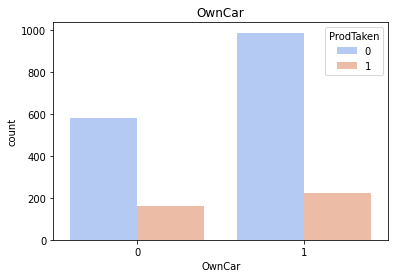

In [10]:
sns.countplot(x='OwnCar', hue='ProdTaken',  data=train, palette=palette).set(title='OwnCar')  # 자동차 보유자의 비율이 크지만 여행신청 비율은 미보유자와 큰 차이가 없다.

In [11]:
# 수치형으로 변환된 데이터 요약
train.describe() 

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,ProdTaken
count,1955.000000,1861.000000,1945.000000,1955.000000,1853.000000,1955.000000,1955.000000,1955.000000,1942.000000,1955.000000,1945.000000,1955.000000,1898.000000,1955.000000,1955.000000,1955.000000,1928.000000,1955.000000,1855.000000,1955.000000
mean,978.000000,37.462117,1.291003,1.641432,15.524015,0.590793,0.382609,2.922762,3.718332,2.738107,3.568638,1.309463,3.255532,0.291049,3.067519,0.619437,1.213174,2.738107,23624.108895,0.195908
std,564.504207,9.189948,0.454342,0.908744,8.150057,0.641707,0.486148,0.712276,1.004095,1.202588,0.793196,0.977164,1.814698,0.454362,1.372915,0.485649,0.859450,1.202588,5640.482258,0.397000
min,1.000000,18.000000,1.000000,1.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1000.000000,0.000000
25%,489.500000,31.000000,1.000000,1.000000,9.000000,0.000000,0.000000,2.000000,3.000000,2.000000,3.000000,1.000000,2.000000,0.000000,2.000000,0.000000,1.000000,2.000000,20390.000000,0.000000
50%,978.000000,36.000000,1.000000,1.000000,14.000000,1.000000,0.000000,3.000000,4.000000,3.000000,3.000000,1.000000,3.000000,0.000000,3.000000,1.000000,1.000000,3.000000,22295.000000,0.000000
75%,1466.500000,43.000000,2.000000,3.000000,20.000000,1.000000,1.000000,3.000000,4.000000,4.000000,4.000000,2.000000,4.000000,1.000000,4.000000,1.000000,2.000000,4.000000,25558.000000,0.000000
max,1955.000000,61.000000,2.000000,3.000000,36.000000,3.000000,1.000000,5.000000,6.000000,4.000000,5.000000,3.000000,19.000000,1.000000,5.000000,1.000000,3.000000,4.000000,98678.000000,1.000000


In [12]:
# min, max가 평균과 크게 차이나는 'NumberOfTrips', 'MonthlyIncome' 데이터 이상치 확인
# 'MonthlyIncome' 상관계수 확인
train.corrwith(train['MonthlyIncome'])

id                          0.032920
Age                         0.440733
TypeofContact              -0.039107
CityTier                    0.057705
DurationOfPitch             0.016011
Occupation                 -0.037049
Gender                      0.024985
NumberOfPersonVisiting      0.168701
NumberOfFollowups           0.194668
ProductPitched             -0.579170
PreferredPropertyStar      -0.024338
MaritalStatus              -0.132442
NumberOfTrips               0.137093
Passport                    0.017044
PitchSatisfactionScore     -0.005497
OwnCar                      0.109662
NumberOfChildrenVisiting    0.179255
Designation                -0.579170
MonthlyIncome               1.000000
ProdTaken                  -0.140617
dtype: float64

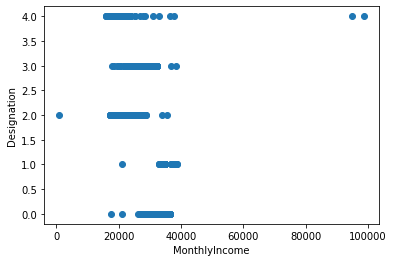

In [13]:
# 'MonthlyIncom' 이상치 확인
plt.scatter(train.MonthlyIncome, train.Designation)
plt.xlabel('MonthlyIncome')
plt.ylabel('Designation')
plt.show()

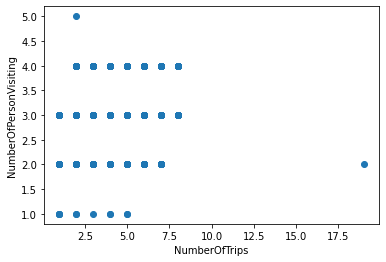

In [14]:
# 'NumberOfTrips' 이상치 확인
plt.scatter(train.NumberOfTrips, train.NumberOfPersonVisiting)
plt.xlabel('NumberOfTrips')
plt.ylabel('NumberOfPersonVisiting')
plt.show()

In [15]:
# 이상치 인덱스 확인
train['MonthlyIncome'].sort_values(ascending=False)  # 1338, 604


1338    98678.0
604     95000.0
827     38651.0
1518    38604.0
314     38537.0
         ...   
1897        NaN
1911        NaN
1912        NaN
1914        NaN
1923        NaN
Name: MonthlyIncome, Length: 1955, dtype: float64

In [16]:
train['MonthlyIncome'].sort_values(ascending=True)  # 189

189      1000.0
838     16009.0
538     16052.0
1505    16091.0
73      16118.0
         ...   
1897        NaN
1911        NaN
1912        NaN
1914        NaN
1923        NaN
Name: MonthlyIncome, Length: 1955, dtype: float64

In [17]:
# 이상치 인덱스 확인
train['NumberOfTrips'].sort_values(ascending=False)  # 987

987     19.0
1828     8.0
303      8.0
1404     8.0
1598     8.0
        ... 
1822     NaN
1856     NaN
1899     NaN
1906     NaN
1927     NaN
Name: NumberOfTrips, Length: 1955, dtype: float64

In [18]:
# 이상치 제거
train.drop(index=[189, 604, 1338, 987], inplace=True) 

In [19]:
# 결측치 처리
ls = ['DurationOfPitch', 'TypeofContact']  # 'TypeofContact'은 Unknown(0), 'DurationOfPitch'는 기간(0)으로 판단하고 처리했습니다.
for these in [train, test]:
    for col in ls:
        these[col].fillna(0, inplace=True) 

# 'PreferredPropertyStar', 'NumberOfTrips', 'Age'는 상관계수가 높은 컬럼의 그룹별 평균값으로 처리했습니다.
for these in [train, test]:
        these['PreferredPropertyStar'].fillna(train.groupby('NumberOfTrips')['PreferredPropertyStar'].transform('mean'), inplace=True)  
        these['NumberOfTrips'].fillna(train.groupby('DurationOfPitch')['NumberOfTrips'].transform('mean'), inplace=True)
        these['Age'].fillna(train.groupby('Designation')['Age'].transform('mean'), inplace=True)

In [20]:
# 비교적 값이 큰 데이터 스케일링
scaler = RobustScaler() 
train[['Age', 'DurationOfPitch']] = scaler.fit_transform(train[['Age', 'DurationOfPitch']])
test[['Age', 'DurationOfPitch']] = scaler.transform(test[['Age', 'DurationOfPitch']])

In [21]:
# 중요도 낮다고 판단한 컬럼 제거하고 train_data를 x, y로 분리
train.drop(columns=['id', 'NumberOfChildrenVisiting', 'NumberOfPersonVisiting', 'OwnCar', 'MonthlyIncome', 'NumberOfFollowups'], axis=1, inplace=True)
test.drop(columns=['id', 'NumberOfChildrenVisiting', 'NumberOfPersonVisiting', 'OwnCar', 'MonthlyIncome', 'NumberOfFollowups'], axis=1, inplace=True)
# 상관관계 분석도를 참고해 상관계수가 낮은 'NumberOfChildrenVisiting', 'NumberOfPersonVisiting' 드롭했습니다.
# 'OwnCar'은 자동차 보유자와 미보유자의 차이는 큰 반면 여행신청 비율은 큰 차이가 나지 않아 드롭했습니다.('Gender'도 비슷한 양상이나 드롭하면 정확도가 떨어져 제외)
# 'MonthlyIncome'은 결측치가 워낙 많고 'Age', 'DurationOfPitch', 'Designation' 등의 컬럼으로 충분히 대체가 될거라 판단해 드롭했습니다.
# 'NumberOfFollowups'은 불필요하다고 판단한 위의 컬럼들과 상관계수가 높고 다른 컬럼들과는 상관계수가 낮아 드롭했습니다.

x = train.drop(columns=['ProdTaken'], axis=1)
y = train[['ProdTaken']]

In [22]:
# k-fold
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [23]:
# CatBoostClassifier 정의, 훈련
cat_params = {
    # 'depth': [10, 11, 14, 15],
    'l2_leaf_reg': [9.122611898980937],    
    'learning_rate': [0.279118773316628],
    'model_size_reg': [5.669787571831169],
    # 'n_estimators': [200, 300, 400, 500, 600],
    'od_pval': [0.0],
}   
# 하이퍼파라미터는 BayesianOptimization을 이용해 적절한 파라미터를 찾고, 최종적으로 GridSearchCV를 이용해 'depth'와 'n_estimators'를 조절하며 최선의 하이퍼파라미터를 찾았습니다.

cat = CatBoostClassifier(verbose=2, depth=14, n_estimators=200, allow_writing_files=False)  
grid_cv = GridSearchCV(cat,
                       param_grid=cat_params,
                       cv=k_fold,
                       n_jobs=-1)

grid_cv.fit(x, y.values.ravel())

model = grid_cv.best_estimator_
model.fit(x, y.values.ravel())

grid_cv.best_score_

0:	learn: 0.5795893	total: 167ms	remaining: 33.3s
2:	learn: 0.3847641	total: 211ms	remaining: 13.9s
4:	learn: 0.3015673	total: 278ms	remaining: 10.8s
6:	learn: 0.2486469	total: 360ms	remaining: 9.91s
8:	learn: 0.2110174	total: 411ms	remaining: 8.72s
10:	learn: 0.1779999	total: 478ms	remaining: 8.22s
12:	learn: 0.1541392	total: 535ms	remaining: 7.7s
14:	learn: 0.1356218	total: 611ms	remaining: 7.53s
16:	learn: 0.1213893	total: 705ms	remaining: 7.58s
18:	learn: 0.1094883	total: 780ms	remaining: 7.43s
20:	learn: 0.0997398	total: 848ms	remaining: 7.23s
22:	learn: 0.0904833	total: 924ms	remaining: 7.11s
24:	learn: 0.0811146	total: 960ms	remaining: 6.72s
26:	learn: 0.0749689	total: 1.02s	remaining: 6.57s
28:	learn: 0.0696092	total: 1.09s	remaining: 6.42s
30:	learn: 0.0651155	total: 1.15s	remaining: 6.27s
32:	learn: 0.0611034	total: 1.21s	remaining: 6.13s
34:	learn: 0.0573905	total: 1.27s	remaining: 5.99s
36:	learn: 0.0543763	total: 1.33s	remaining: 5.85s
38:	learn: 0.0515644	total: 1.39s	rem

0.9415829408686551

In [24]:
# 제출
y_summit = model.predict(test)
sample_submission['ProdTaken'] = y_summit
sample_submission.to_csv('../travel/save/sample_submission.csv', index=False)
np.unique(y_summit, return_counts=True)

(array([0, 1], dtype=int64), array([2429,  504], dtype=int64))